In [103]:
from pathlib import Path
base_path = Path("/cta/share/users/ProteinGym/DMS_Assays(Substitutions)")
list(base_path.glob("*.csv"))[:5]

[PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/VG08_BPP22_Tsuboyama_2023_2GP8.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/CAPSD_AAV2S_Sinai_2021.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/A0A192B1T2_9HIV1_Haddox_2018.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/ESTA_BACSU_Nutschel_2020.csv'),
 PosixPath('/cta/share/users/ProteinGym/DMS_Assays(Substitutions)/SAV1_MOUSE_Tsuboyama_2023_2YSB.csv')]

In [104]:
import pandas as pd
# df = pd.concat((pd.read_csv(file) for file in base_path.rglob("*.csv")), ignore_index=True)
files = list(base_path.rglob("*.csv"))
proteins = [pd.read_csv(file) for file in files]

In [105]:
import numpy as np

# Given a dataframe containing a DMS assay belongin to a single protein (from single .csv file)
# Calculate the original sequence and functional map of that sequence 
def extract_func_map(df):
    df = df[~df["mutant"].str.contains(":")].copy() # Cant handle multiple mutations right now
    idx = df["mutant"].first_valid_index()
    mut = df["mutant"][idx]
    mut_seq = df["mutated_sequence"][idx]
    mut_pos = int(mut[1:-1])
    ori_seq = mut_seq[:mut_pos-1] + mut[:1] + mut_seq[mut_pos:]
    mu = np.mean(df["DMS_score"])
    stddev = np.std(df["DMS_score"])
    df["Z_scores"] = (df["DMS_score"] - mu)/stddev
    df["mut_positions"] = df["mutant"].apply(lambda x: int(x[1:-1]) - 1)
    func_map = df.groupby("mut_positions")["Z_scores"].mean()
    func_vals = np.zeros((len(ori_seq), ))
    func_vals.fill(np.nan)
    func_vals[func_map.index.to_numpy()] = func_map.to_numpy()
    return ori_seq, func_vals
    

In [106]:
sequences = []
func_maps = []

for i, prot in enumerate(proteins):
    if prot["mutant"].str.contains(":").sum() > 0:
        continue
    print(f"Processing {i}th protein")
    seq, func = extract_func_map(prot)
    sequences.append(seq)
    func_maps.append(func)

Processing 0th protein
Processing 2th protein
Processing 3th protein
Processing 5th protein
Processing 6th protein
Processing 7th protein
Processing 8th protein
Processing 9th protein
Processing 10th protein
Processing 12th protein
Processing 13th protein
Processing 14th protein
Processing 15th protein
Processing 16th protein
Processing 17th protein
Processing 18th protein
Processing 21th protein
Processing 25th protein
Processing 27th protein
Processing 30th protein
Processing 31th protein
Processing 37th protein
Processing 38th protein
Processing 39th protein
Processing 40th protein
Processing 43th protein
Processing 45th protein
Processing 46th protein
Processing 48th protein
Processing 49th protein
Processing 50th protein
Processing 51th protein
Processing 52th protein
Processing 53th protein
Processing 54th protein
Processing 55th protein
Processing 56th protein
Processing 57th protein
Processing 58th protein
Processing 59th protein
Processing 60th protein
Processing 61th protein


In [107]:
from tokenizers import Tokenizer

In [108]:
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_bpe_51200.json"
tkz1 = Tokenizer.from_file(tkz_path)
tkz_path = "/cta/share/users/mutbpe/tokenizers/blosum62/hf_uniref50_mutbpe_0.7_3_12_0.05_51200.json"
tkz2 = Tokenizer.from_file(tkz_path)

In [109]:
tkz1_vals = []
tkz2_vals = []
for i, seq in enumerate(sequences):
    offs1 = tkz1.encode(seq).offsets
    offs2 = tkz2.encode(seq).offsets
    func_map = np.abs(func_maps[i])
    # func_map = func_maps[i]
    for s, e in offs1:
        tkz1_vals.append(np.mean(func_map[s:e]))
    for s, e in offs2:
        tkz2_vals.append(np.mean(func_map[s:e]))


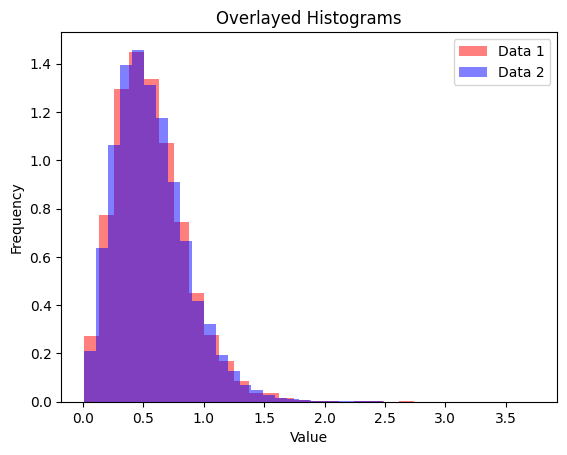

In [110]:
import matplotlib.pyplot as plt
plt.hist(tkz1_vals, bins=30, alpha=0.5, color='red', label='Data 1', density=True)
plt.hist(tkz2_vals, bins=30, alpha=0.5, color='blue', label='Data 2',  density=True)

# Add legend and labels
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms')

plt.show()

In [111]:
np.mean(tkz2_vals)

np.float64(nan)

- Disagreement olan tokenlari incele, agreement olan tokenlardan geriye kalan bolgelere bak

In [112]:
set(offs2) - set(offs1)


{(4, 8), (8, 11), (11, 15), (28, 32), (32, 34), (34, 37), (51, 54), (54, 55)}

In [113]:
tkz1_vals = []
tkz2_vals = []
for i, seq in enumerate(sequences):
    offs1 = tkz1.encode(seq).offsets
    offs2 = tkz2.encode(seq).offsets
    func_map = np.abs(func_maps[i])
    # func_map = func_maps[i]
    for s, e in (set(offs1) - set(offs2)):
        tkz1_vals.append(np.mean(func_map[s:e]))
    for s, e in (set(offs2) - set(offs1)):
        tkz2_vals.append(np.mean(func_map[s:e]))

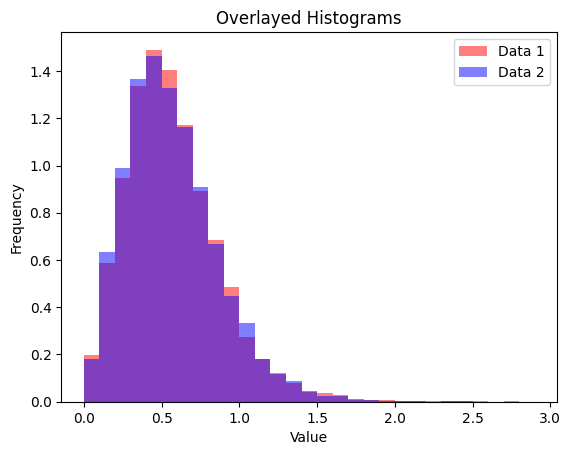

In [114]:
import matplotlib.pyplot as plt
plt.hist(tkz1_vals, bins=np.arange(0, 3, 0.1), alpha=0.5, color='red', label='Data 1', density=True)
plt.hist(tkz2_vals, bins=np.arange(0, 3, 0.1), alpha=0.5, color='blue', label='Data 2',  density=True)

# Add legend and labels
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Overlayed Histograms')

plt.show()

In [115]:
len(tkz2_vals)

13537